In [ ]:
#Reference
#DCGAN Tutorial:
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

#Reference
DCGAN Tutorial:
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
Gao, F., Yang, Y., Wang, J., Sun, J., Yang, E., Zhou, H. (2018). A deep convolutional generative adversarial networks (DCGANs)­based semi­supervised method for object recognition in
synthetic aperture radar (SAR) images.
https://arxiv.org/pdf/1511.06434.pdf

In [ ]:
#this is for google colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Aug 12 10:21:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler
from torchvision import datasets, transforms
import pickle as pkl
random.seed(777)
torch.manual_seed(777)

In [ ]:
dataset = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([
    transforms.Resize([64,64])
    ,transforms.ToTensor()
    ,transforms.Normalize(0.5,0.5)]), 
    download = True,            
)
idx = dataset.train_labels==8
dataset.targets = dataset.targets[idx]
dataset.data = dataset.data[idx]

In [ ]:
nc=1
batch_size=128
num_epochs = 20
record_every=10
dataloader=DataLoader(dataset,num_workers=0,batch_size=batch_size,shuffle=True)#load 128 images per batch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path='drive/MyDrive/models/'
sample_path='drive/MyDrive/training_results/'

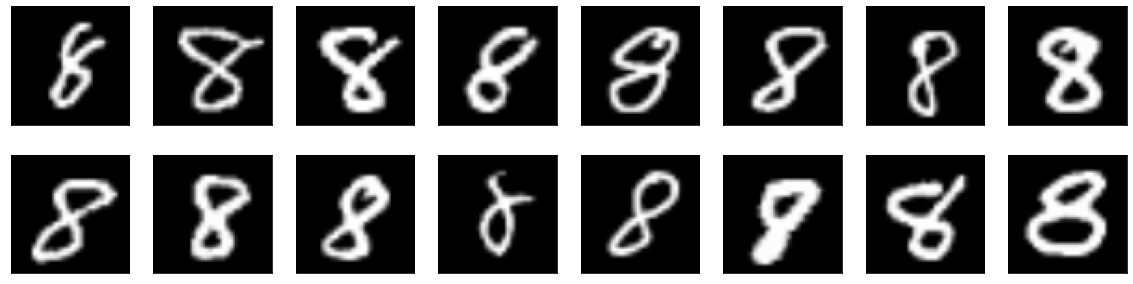

In [ ]:
def Gshow(img): #show gray scale images
  img=img.numpy()
  img_=img.reshape(64,64) #reshape from 64*64*1 to 64*64 as imshow(cmap='gray) only takes two values
  plt.imshow(img_,cmap='gray')# 64*64

dataiter=iter(dataloader)
images,labels=dataiter.next()
plot_only=16 #plot only 16 images
fig=plt.figure(1,figsize=(20,5))
for idx in range(plot_only):
  ax=fig.add_subplot(2,plot_only/2,idx+1,xticks=[],yticks=[])
  Gshow(images[idx])

In [ ]:
def weights_init(model):
  cname=model.__class__.__name__
  #print(cname.find('Conv'))
  if (cname.find('Conv')!=-1) or (cname.find('Linear')!=-1):
    model.weight.data.normal_(0.0, 0.02)
    if hasattr(model, 'bias') and model.bias != None:
      model.bias.data.zero_()

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.conv_proj = nn.Conv2d(100, 512, kernel_size=3, padding=1)
    self.bn_proj = nn.BatchNorm2d(512)
    self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(256)
    self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.conv4 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    
  def forward(self,x):
    x=x.reshape(x.shape[0], x.shape[1], 1, 1) # b* 100* 1* 1
    x=F.interpolate(x,[4,4]) #batch_size* 100* 4* 4
    x=F.relu(self.bn_proj(self.conv_proj(x)))
    x=F.interpolate(x,[8,8]) #batch_size* 512* 8* 8
    x=F.relu(self.bn1(self.conv1(x)))
    x=F.interpolate(x,[16,16]) #batch_size* 256* 16* 16
    x=F.relu(self.bn2(self.conv2(x)))
    x=F.interpolate(x,[32,32]) #batch_size* 128* 32* 32
    x=F.relu(self.bn3(self.conv3(x)))
    x=F.interpolate(x,[64,64]) #batch_size* 64* 64* 64
    x=self.conv4(x) #batch_size* 1* 64* 64
    out=torch.tanh(x)
    return out

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,n_features=512,n_channels=1):
    super(Discriminator,self).__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(256)
    self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(512)
    self.classifier = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
    self.sigm=nn.Sigmoid()
    
  def forward(self,x):
    #initial x: batch_size* 1* 64* 64
    x = F.leaky_relu(self.conv1(x),0.2) #batch_size* 64* 32*32
    x = F.leaky_relu(self.bn2(self.conv2(x)),0.2) #batch_size* 128* 16*16
    x = F.leaky_relu(self.bn3(self.conv3(x)),0.2) #batch_size* 256* 8*8
    x = F.leaky_relu(self.bn4(self.conv4(x)),0.2) #batch_size* 512* 4*4
    out = self.sigm(self.classifier(x)) #out: batch_size* 1* 1*1
    return out

In [ ]:
def D_loss(D, G, real_images, batch_size):
  z=torch.randn([batch_size, 100],device=device)
  fake_images=G(z)
  real_labels=torch.ones(batch_size, device=device)
  fake_labels=torch.zeros(batch_size, device=device)
  criterion=nn.BCELoss()
  #D_loss1: Maximize log(D(x)) -> Minimize -log(D(x))
  #BCELoss: -[1*log(D(real)) + (1-1)*log(1-D(real))] -> -log(D(real))
  D_loss1=criterion(D(real_images).squeeze(), real_labels)
  #D_loss2: Maximize log(1-D(G(z))) -> Minimize -log(1-D(G(z)))
  #BCELoss: -[0*log(D(fake)) + (1-0)*log(1-D(fake))] -> -log(1-D(fake))
  D_loss2=criterion(D(fake_images).squeeze(), fake_labels)
  return D_loss1+D_loss2

In [ ]:
def G_loss(D, G, batch_size):
  z=torch.randn([batch_size, 100],device=device)
  fake_images=G(z)
  real_labels=torch.ones(batch_size, device=device)
  criterion=nn.BCELoss()
  G_loss=criterion(D(fake_images).squeeze(), real_labels)
  return G_loss

In [ ]:
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(weights_init),G.apply(weights_init)
optim_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
optim_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))
dataloader = DataLoader(dataset, num_workers=0, batch_size=64, shuffle=True)

losses=[]
d_loss_sum,g_loss_sum=0,0
fixed_z = torch.randn([16, 100],device=device)
for epoch in range(num_epochs):
  for batch_i, (real_images, _) in enumerate(dataloader):
    batch_size = real_images.size(0)
    real_images = real_images.to(device)
    #train D
    optim_D.zero_grad()
    d_loss = D_loss(D, G, real_images, batch_size)
    d_loss.backward()
    optim_D.step()
    #train G
    optim_G.zero_grad()
    g_loss = G_loss(D, G, batch_size)
    g_loss.backward()
    optim_G.step()

    d_loss_sum+=d_loss.item()
    g_loss_sum+=g_loss.item()
    # Print some loss stats
    if batch_i % record_every==0 and batch_i!=0:
      # append discriminator loss and generator loss
      losses.append((d_loss_sum/record_every,g_loss_sum/record_every))
      # print discriminator and generator loss
      print('Epoch [{:5d}/{:5d}] |Batch [{:5d} ~{:5d}] | AVG_D_loss: {:6.4f} | AVG_G_loss: {:6.4f}'.format(
                      epoch+1, num_epochs, batch_i-record_every, batch_i, d_loss_sum/record_every, g_loss_sum/record_every))
      d_loss_sum,g_loss_sum=0,0

  ## AFTER EACH EPOCH ##
  with torch.no_grad():
    with open(sample_path+'train_samplesG_MNIST_'+str(epoch+1)+'.pkl', 'wb') as f:
      pkl.dump(G(fixed_z).cpu(), f)


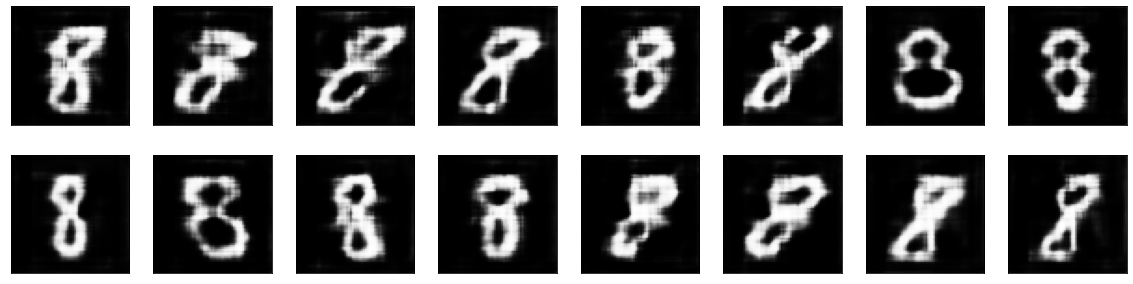

In [ ]:
def view_samples(samples, nc=3):
  fig, axes = plt.subplots(figsize=(20,5), nrows=2, ncols=8, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img=img/2+0.5
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(img.reshape((64,64)),cmap='Greys_r')
with open('drive/MyDrive/training_results/train_samplesG_MNIST_7.pkl', 'rb') as f:
  samples = pkl.load(f)
  view_samples(samples, nc=1)